# MMM-Oxford 2x2 SARS-CoV-2 truth set

Comparing SARS2-positive samples from a mixture of cultured and high Ct OUH clinical samples using combinations of:
1. Nanopore and Illumina sequencing
2. ARTIC v3 amplicon sequencing and SISPA whole genome amplification

---

## Notes

### Field descriptions

- `name`: Primary identifier comprising `class_`, `sample` and `replicate`
- `class_`: Concatenation of organisation, `amplification` method and sequencing `platform`
    - `{'mmm-artic-ill', 'mmm-artic-ont', 'mmm-sispa-ill', 'mmm-sispa-ont', 'phe-sispa-ill', 'phe-sispa-ont'}`
- `sample`: Truncated SHA1 digest of the original identifying sample name/accession
    - `'s' + str(int(hashlib.sha1(x.encode()).hexdigest(), 16)).str[:6]`
- `replicate`: Replicate of a given `sample`-`platform`-`amplification` combination
- `origin`: Whether derived from tissue culture or a clinical specimen
    - `{'culture', 'clinical'}`
- `amplification`: Amplification methodology
    - `{'artic', 'sispa'}`
- `platform`: Sequencing platform
    - `{'ont', 'ill'}`
- `fastq_filename`: Fastq filename(s) globbed with asterisk. One for ONT, two for Illumina samples:
    - Oxford Nanopore (`platform == 'ont'`)
        - `{name}.fastq.gz` (e.g. `mmm-artic-ont-s10370-1.fastq.gz`)
    - Illumina (`platform == 'ill'`):
        - `{name}_1.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_1.fastq.gz`)
        - `{name}_2.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_2.fastq.gz`)
- `oci_bucket`: Parent bucket in the Oracle Cloud SP3 tenancy

### FASTQ locations
- OCI bucket: `SARS-CoV-2_reference_ox`
- MMM `analysis1`: `/home/ndm.local/bede/covid/truth/fastq_dehosted/`

## Sequencing
- Illumina: MiSeq, 2x250bp
- ONT: GridION, R9.4.1

### QC

- ONT sequences basecalled with Guppy 4.2.3 (HAC)
- Human sequences (`taxid == 9606`) removed using kraken2 2.1.2 and [Standard-16](https://benlangmead.github.io/aws-indexes/k2)
- `cov20_pc` and `median_depth` calculated from minimap2+samtools depths output using reference `MN908947.3`  

### Caveats

- Pangolin assignments all extrapolated from artic-ont sequence, currently incomplete
- Some samples, generally SISPA have poor coverage
- 100bp Illumina samples to be investigated
- Currently fastq only, however Nanopore fast5s are available

In [1]:
import datetime
import pandas as pd

today = datetime.date.today().isoformat()

pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('mmm-2x2-truth.2021-07-16.csv')
df['oci_bucket'] = 'SARS-CoV-2_reference_ox'

print(f'Length: {df.shape[0]}')
df.head(1)

Length: 309


,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,P.1,3.1.5,SARS-CoV-2_reference_ox


## Lineage distribution

<AxesSubplot:>

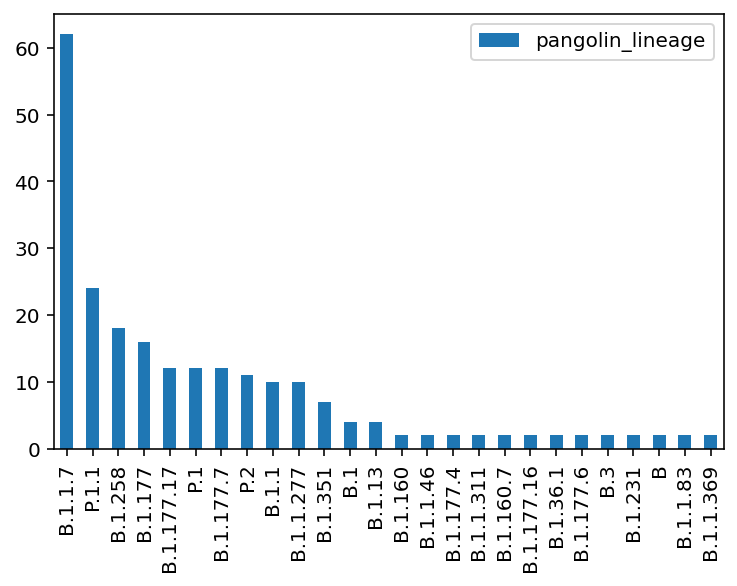

In [3]:
df.pangolin_lineage.value_counts().to_frame().plot.bar()

## Subset 1: Lineage calling of ARTIC v3 matched samples between sequencing platforms

- **25 ARTIC samples with matched ONT + Illumina**
- Distinct lineages
- Matching ONT+Illumina pairs identified by `matched_pair`
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [4]:
lineages_subset_df = (df.query("amplification == 'artic' and cov20_pc >= 95 and pangolin_lineage == pangolin_lineage").groupby(['sample'])
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 2"))

lineages_subset_samples = set(lineages_subset_df.index)

lineages_subset_samples_ont_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage')
                                  .reset_index(drop=True))
lineages_subset_samples_ill_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage')
                                  .reset_index(drop=True))

lineages_subset_samples_ont_df.index.rename('matched_pair', inplace=True)
lineages_subset_samples_ill_df.index.rename('matched_pair', inplace=True)

lineages_subset_samples_ont_df.to_csv(f'test-lineage-assignment-ont.{today}.csv')
lineages_subset_samples_ill_df.to_csv(f'test-lineage-assignment-ill.{today}.csv')


lineages_subset_samples_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-test-lineage-assignment-ont.{today}.csv', header=False, index=False)
lineages_subset_samples_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-test-lineage-assignment-ill.{today}.csv', header=False, index=False)

print(lineages_subset_samples_ont_df.shape[0], lineages_subset_samples_ill_df.shape[0])

25 25


In [5]:
lineages_subset_samples_ont_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
matched_pair,,,,,,,,,,,,,
0,mmm-artic-ont-s10370-1,mmm-artic-ont,clinical,s10370,ont,artic,1,mmm-artic-ont-s10370-1*.fastq.gz,100.0,1509,B.1.1,3.1.5,SARS-CoV-2_reference_ox


In [6]:
lineages_subset_samples_ill_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
matched_pair,,,,,,,,,,,,,
0,mmm-artic-ill-s10370-1,mmm-artic-ill,clinical,s10370,ill,artic,1,mmm-artic-ill-s10370-1*.fastq.gz,95.507655,648,B.1.1,3.1.5,SARS-CoV-2_reference_ox


## Subset 2: reproducibility of within-platform ARTIC v3 replicates

- **10 samples x 2 replicates (ONT)**
- **11 samples x 2 replicates (Illumina)**
- Distinct lineages
- Matched within-platform pairs denoted by `matched_pair` field
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [7]:
repro_subset_ont_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ont' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ont = set(repro_subset_ont_df.index)
repro_subset_samples_ont_df = df.query("sample in @repro_subset_samples_ont and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])

repro_subset_ill_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ill' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ill = set(repro_subset_ill_df.index)
repro_subset_samples_ill_df = df.query("sample in @repro_subset_samples_ill and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])

repro_subset_samples_ont_df['matched_pair'] = repro_subset_samples_ont_df.groupby('sample').ngroup()
repro_subset_samples_ill_df['matched_pair'] = repro_subset_samples_ill_df.groupby('sample').ngroup()

repro_subset_samples_ont_df.to_csv(f'test-repro-assignment-ont.{today}.csv', index=False)
repro_subset_samples_ill_df.to_csv(f'test-repro-assignment-ill.{today}.csv', index=False)

repro_subset_samples_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-test-repro-assignment-ont.{today}.csv', header=False, index=False)
repro_subset_samples_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-test-repro-assignment-ill.{today}.csv', header=False, index=False)

print(repro_subset_samples_ont_df.shape[0], repro_subset_samples_ill_df.shape[0])

20 22


In [8]:
repro_subset_samples_ont_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket,matched_pair
253,mmm-artic-ont-s11511-1,mmm-artic-ont,clinical,s11511,ont,artic,1,mmm-artic-ont-s11511-1*.fastq.gz,100.0,2106,B.1.177,3.1.5,SARS-CoV-2_reference_ox,0


In [9]:
repro_subset_samples_ill_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket,matched_pair
251,mmm-artic-ill-s11511-1,mmm-artic-ill,clinical,s11511,ill,artic,1,mmm-artic-ill-s11511-1*.fastq.gz,100.0,5313,B.1.177,3.1.5,SARS-CoV-2_reference_ox,0


## Samples for which 2x2 comparison is available

In [10]:
# 2x2 samples exist
twobytwo_df = (df.groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_df.index.nunique())

# 2x2 samples exist and >= 95% cov20
twobytwo_95_df = (df.query("cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_95_df.index.nunique())

# ONT + Illumina and >= 95% cov20 
artic_both_platforms_95_df = (df.query("amplification == 'artic' and cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['platform']
 .to_frame()
 .query("platform == 2"))
artic_both_platforms_95_df
print(artic_both_platforms_95_df.index.nunique())

23
12
52


## Everything

In [11]:
df[['oci_bucket', 'name']].to_csv('sp3-mmm-2x2-truth.2021-07-16.csv', header=False, index=False)

df

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,P.1,3.1.5,SARS-CoV-2_reference_ox
1,mmm-artic-ill-s24350-2,mmm-artic-ill,culture,s24350,ill,artic,2,mmm-artic-ill-s24350-2*.fastq.gz,99.969782,2474,P.1,3.1.5,SARS-CoV-2_reference_ox
2,mmm-artic-ill-s24350-3,mmm-artic-ill,culture,s24350,ill,artic,3,mmm-artic-ill-s24350-3*.fastq.gz,99.969782,7507,P.1,3.1.5,SARS-CoV-2_reference_ox
3,mmm-artic-ont-s24350-1,mmm-artic-ont,culture,s24350,ont,artic,1,mmm-artic-ont-s24350-1*.fastq.gz,100.000000,961,P.1,3.1.5,SARS-CoV-2_reference_ox
4,mmm-artic-ont-s24350-2,mmm-artic-ont,culture,s24350,ont,artic,2,mmm-artic-ont-s24350-2*.fastq.gz,100.000000,2956,P.1,3.1.5,SARS-CoV-2_reference_ox
5,mmm-artic-ont-s24350-3,mmm-artic-ont,culture,s24350,ont,artic,3,mmm-artic-ont-s24350-3*.fastq.gz,100.000000,4068,P.1,3.1.5,SARS-CoV-2_reference_ox
6,mmm-sispa-ill-s24350-1,mmm-sispa-ill,culture,s24350,ill,sispa,1,mmm-sispa-ill-s24350-1*.fastq.gz,100.000000,11651,P.1,3.1.5,SARS-CoV-2_reference_ox
7,mmm-sispa-ill-s24350-2,mmm-sispa-ill,culture,s24350,ill,sispa,2,mmm-sispa-ill-s24350-2*.fastq.gz,100.000000,9957,P.1,3.1.5,SARS-CoV-2_reference_ox
8,mmm-sispa-ill-s24350-3,mmm-sispa-ill,culture,s24350,ill,sispa,3,mmm-sispa-ill-s24350-3*.fastq.gz,99.996642,7626,P.1,3.1.5,SARS-CoV-2_reference_ox
9,mmm-sispa-ont-s24350-1,mmm-sispa-ont,culture,s24350,ont,sispa,1,mmm-sispa-ont-s24350-1*.fastq.gz,100.000000,647,P.1,3.1.5,SARS-CoV-2_reference_ox
